# 1. Import Libraries and Set Directory
---

Import Libraries

In [1]:
is_drive = 0

In [2]:
if is_drive==1 :
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# directory management
import os
from glob import glob
# regular imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# imports for NN
import tensorflow as tf
from tensorflow import keras
import time

# 2. Load Dataset
---

In [4]:
# Spectogram Path
if is_drive==1 :   
    TRAIN_DIR = "/content/drive/MyDrive/spectogram-dataset/Train/"
    TEST_DIR = "/content/drive/MyDrive/spectogram-dataset/Test/"
    AE_SPECTROGRAMS_SAVE_DIR1 = "/content/drive/MyDrive/autoencoder-generations/Generated-Test/"
    E_SPECTROGRAMS_SAVE_DIR1 = "/content/drive/MyDrive/autoencoder-generations/Compressed-Test/"
    AE_SPECTROGRAMS_SAVE_DIR2 = "/content/drive/MyDrive/autoencoder-generations/Generated-Train/"
    E_SPECTROGRAMS_SAVE_DIR2 = "/content/drive/MyDrive/autoencoder-generations/Compressed-Train/"
else :
    TRAIN_DIR = "../Project/spectogram-dataset/Train/"
    TEST_DIR = "../Project/spectogram-dataset/Test/"
    AE_SPECTROGRAMS_SAVE_DIR1 = "../Project/autoencoder-generations/Generated-Test/"
    E_SPECTROGRAMS_SAVE_DIR1 = "../Project/autoencoder-generations/Compressed-Test/"
    AE_SPECTROGRAMS_SAVE_DIR2 = "../Project/autoencoder-generations/Generated-Train/"
    E_SPECTROGRAMS_SAVE_DIR2 = "../Project/autoencoder-generations/Compressed-Train/"

In [5]:
def load_fsdd(the_path):
    x_train = []
    for root, _, file_names in os.walk(the_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_train.append(spectrogram)
    x_train = np.array(x_train)        # -> (n_samples, n_bins, n_frames)
    x_train = x_train[..., np.newaxis] # -> (1200, 800, 32, 1)
    
    return x_train

In [6]:
x_train_raw = load_fsdd(TRAIN_DIR)
x_test_raw  = load_fsdd(TEST_DIR)

AE_test = load_fsdd(AE_SPECTROGRAMS_SAVE_DIR1)
E_test = load_fsdd(E_SPECTROGRAMS_SAVE_DIR1)

AE_train = load_fsdd(AE_SPECTROGRAMS_SAVE_DIR2)
E_train = load_fsdd(E_SPECTROGRAMS_SAVE_DIR2)

AE_test = AE_test[:, :, :, :, 0]
AE_train = AE_train[:, :, :, :, 0]

In [7]:
print("x_train_raw" , x_train_raw.shape)
print("x_test_raw" , x_test_raw.shape)
print("\n")
print("AE_test" , AE_test.shape)
print("E_test" , E_test.shape)
print("\n")
print("AE_train" , AE_train.shape)
print("E_train" , E_train.shape)

x_train_raw (1200, 160, 84, 1)
x_test_raw (300, 160, 84, 1)


AE_test (300, 160, 84, 1)
E_test (300, 16, 1)


AE_train (1200, 160, 84, 1)
E_train (1200, 16, 1)


In [56]:
num_classes = 10
iterations = 0
i = 0
y_train = []
while iterations!=len(x_train_raw):
    iterations +=1
    y_train.append(i)
    i += 1
    if i == num_classes :
        i = 0
y_train = np.array(y_train)
#---------------------------------------------------------------#
iterations = 0
i = 0
y_test =[]
while iterations!=len(x_test_raw):
    iterations +=1
    y_test.append(i)
    i += 1
    if i == num_classes :
        i = 0
y_test = np.array(y_test)

In [58]:
print(y_train[0], y_train[5], y_test[9])

0 5 9


# 3. Create Classifer

In [10]:
import keras
from keras import layers
from keras import Model

In [195]:
classifier = keras.Sequential(name="classifier")

# Convolutional layer 1
classifier.add(layers.Conv2D(16, (1, 1), activation='relu', 
                input_shape=(16, 1, 1), padding='valid', name = 'Conv2D_1'))

classifier.add(layers.BatchNormalization(name = 'BN_1'))

# Average pooling layer 1
#classifier.add(layers.AveragePooling2D(pool_size=(1, 1), strides=(2, 2), padding='valid'))

# Convolutional layer 2
classifier.add(layers.Conv2D(32, (1, 1), activation='relu', padding='valid', name = 'Conv2D_2'))

classifier.add(layers.BatchNormalization(name = 'BN_2'))

# Average pooling layer 2
#classifier.add(layers.AveragePooling2D(pool_size=(1, 1), strides=(2, 2), padding='valid'))

# Flatten layer
classifier.add(layers.Flatten(name = 'Flatten_1'))

# Fully connected layer 1
#classifier.add(layers.Dense(120, activation='relu'))

# Fully connected layer 2
classifier.add(layers.Dense(84, activation='relu', name = 'Dense_1'))

classifier.add(layers.Dropout(0.5, name = 'Drop_1'))

# Output layer
classifier.add(layers.Dense(10, activation='softmax', name = 'Dense_2'))

classifier.summary() 

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 16, 1, 16)         32        
                                                                 
 BN_1 (BatchNormalization)   (None, 16, 1, 16)         64        
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 1, 32)         544       
                                                                 
 BN_2 (BatchNormalization)   (None, 16, 1, 32)         128       
                                                                 
 Flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 Dense_1 (Dense)             (None, 84)                43092     
                                                                 
 Drop_1 (Dropout)            (None, 84)                0

In [196]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 30

In [197]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
mse_loss = keras.losses.SparseCategoricalCrossentropy()
classifier.compile(optimizer=optimizer, loss=mse_loss, metrics=['accuracy'])

In [198]:
hist = classifier.fit(E_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      shuffle=True,
                      validation_data=(E_test,y_test))

Epoch 1/30
38/38 [==============================] - 1s 9ms/step - loss: 2.2115 - accuracy: 0.2850 - val_loss: 1.6557 - val_accuracy: 0.4833
Epoch 2/30
38/38 [==============================] - 0s 8ms/step - loss: 1.2067 - accuracy: 0.6008 - val_loss: 1.1879 - val_accuracy: 0.7267
Epoch 3/30
38/38 [==============================] - 0s 8ms/step - loss: 0.8546 - accuracy: 0.7375 - val_loss: 0.9500 - val_accuracy: 0.7867
Epoch 4/30
38/38 [==============================] - 0s 8ms/step - loss: 0.6755 - accuracy: 0.8000 - val_loss: 0.7793 - val_accuracy: 0.8300
Epoch 5/30
38/38 [==============================] - 0s 8ms/step - loss: 0.5620 - accuracy: 0.8308 - val_loss: 0.6602 - val_accuracy: 0.8333
Epoch 6/30
38/38 [==============================] - 0s 8ms/step - loss: 0.4950 - accuracy: 0.8492 - val_loss: 0.5774 - val_accuracy: 0.8300
Epoch 7/30
38/38 [==============================] - 0s 8ms/step - loss: 0.4349 - accuracy: 0.8600 - val_loss: 0.5073 - val_accuracy: 0.8633
Epoch 8/30
38/38 [==

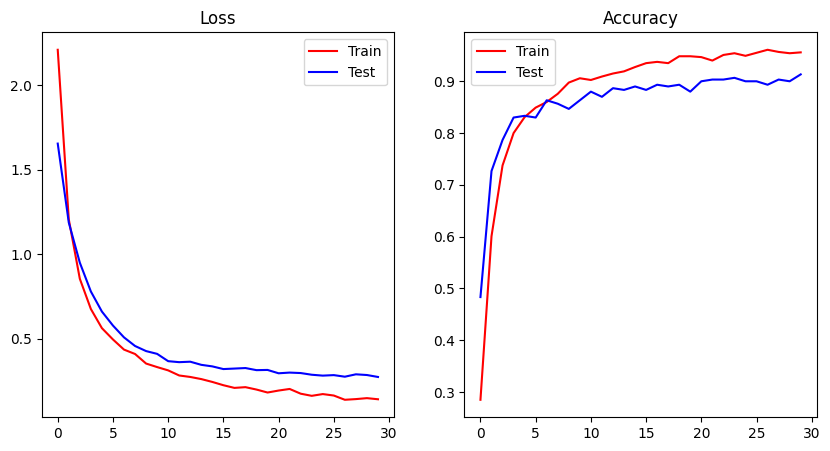

In [199]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.show()

In [200]:
predict_x=classifier.predict(E_test) 
classes_x=np.argmax(predict_x,axis=1)
print("\nShouldBe [0 1 2 3 4 5 6 7 8 9]\n")
y = 0
for i in range(15):
    y = y + 10
    print("\t",classes_x[y:y+10])

10/10 [==============================] - 0s 2ms/step

ShouldBe [0 1 2 3 4 5 6 7 8 9]

	 [0 1 2 3 4 5 6 7 8 9]
	 [7 1 2 3 4 5 6 7 8 9]
	 [7 1 2 3 4 5 6 7 8 9]
	 [0 1 2 3 4 5 6 7 8 9]
	 [0 1 2 3 4 5 6 7 8 9]
	 [0 1 2 3 4 5 6 4 8 9]
	 [0 1 2 3 4 5 6 8 8 9]
	 [0 2 2 2 3 5 6 7 8 9]
	 [0 8 2 2 3 5 6 7 8 9]
	 [0 2 2 3 4 8 6 7 8 9]
	 [0 1 2 3 4 8 6 7 8 9]
	 [0 1 2 3 4 0 6 6 8 9]
	 [0 1 2 3 4 0 6 6 8 9]
	 [0 1 2 3 4 5 4 7 8 9]
	 [0 1 2 3 4 5 6 7 8 9]
